#**CHAPTER 7. HYBRID MOMENTUM REVERSAL**
---

##0.REFERENCE

https://chatgpt.com/share/698e0474-0580-8012-b3ae-daf6047a1ccf

##1.CONTEXT

**Introduction**

This notebook belongs to the series **Mechanism-First Financial Systems — Agentic Trading Laboratories** and implements a governed research laboratory for **Strategy 7: Momentum with Exhaustion Filter**. The goal is not to “predict markets” or to promote a trading recipe. The goal is to create a controlled environment where a practitioner can study a specific economic mechanism: why **momentum** can be persistent at medium horizons, why it can fail abruptly in the presence of **crowding and blow-off dynamics**, and how an explicit **exhaustion filter** changes the mapping from signal to exposure once execution costs, liquidity stress, and regime shifts are taken seriously.

Momentum is often described as a “return continuation anomaly,” but that label is too thin for professional work. In practice, momentum exposure is an interaction between **information diffusion**, **risk-bearing constraints**, and **trade crowding**. Medium-horizon trends can persist when information is revealed gradually, when investor rebalancing is slow, and when limits-to-arbitrage prevent immediate correction. Yet the same mechanism that creates persistence also creates fragility: if many portfolios chase the same winners, inventories become one-sided, marginal liquidity deteriorates, and small shocks can trigger synchronized exits. What looks like continuation can become a **blow-off top**: an accelerating late-stage move accompanied by volatility expansion, followed by reversal when the marginal buyer disappears or when risk constraints bind.

The exhaustion filter is a disciplined attempt to encode that structural intuition. The filter does not claim to “time tops” in the forecasting sense. Instead, it operationalizes a risk hypothesis: momentum becomes structurally unstable when **recent returns** or **realized volatility** become extreme relative to the cross-section. These extremes are interpreted as observable proxies for crowding, forced buying, leverage creep, and the approach to constraint bindingness. The filter therefore modifies the feasible action set of the strategy: the agent is not permitted to allocate to the most extreme names even if their medium-term momentum rank is high. This transforms momentum from a single-signal policy into a two-layer mechanism: a continuation engine plus a constraint-aware exclusion rule.

The notebook’s “market” is synthetic by design. That is not a limitation; it is the point of the laboratory. A mechanism-first laboratory requires that the researcher control the causal levers. The environment therefore generates a benchmark index and a cross-section of equities under a regime process with at least four states (calm, trend, choppy, crash). Each regime is associated with economically interpretable structural parameters: drift and volatility of the benchmark, cross-asset correlation intensity, liquidity stress multipliers, and regime-specific persistence of trends. Crucially for Strategy 7, the synthetic engine embeds **blow-off and reversal structure** in a subset of assets. Those assets exhibit trend acceleration that is not “free alpha,” but rather a prelude to reversal: a stylized representation of momentum crowding and late-cycle instability.

Mechanism-first thinking emphasizes that market objects are better understood as **surfaces** rather than isolated time series. A single price path hides the geometry that matters. In this notebook, several surfaces are central. The first is the **signal surface**: cross-sectional momentum values vary across assets and time, forming a rank-based landscape that the policy traverses. The second is the **exhaustion surface**: a cross-sectional field of recent-return z-scores and volatility z-scores that flags where the momentum surface becomes unsafe to climb. The third is the **execution surface**: a cost field that maps turnover and liquidity stress into realized slippage and impact. The strategy’s realized outcome emerges from how the agent moves across these interacting surfaces under constraints, not from the signal alone.

The notebook is agentic in the precise, engineering sense: it defines a state, a policy, and an environment with explicit transition rules. The environment supplies observations (returns, regimes, liquidity multipliers, volatility proxies). The agent computes signals (medium-term momentum) and computes a constraint indicator (exhaustion). The policy then selects a portfolio subject to feasibility: long-only top-K among non-exhausted names, cash residual permitted, volatility targeting and leverage caps enforced, turnover constrained, and drawdown gates applied. This is “agentic” because the allocation decision is a function of state and is applied repeatedly, producing a closed-loop interaction between the strategy’s trading behavior and its realized exposure to market paths and costs.

Execution realism is essential because Strategy 7 is fundamentally about late-stage dynamics, and late-stage dynamics are precisely when execution frictions worsen. The notebook therefore models transaction costs (spread and slippage) and impact costs that increase with turnover and with a regime-dependent liquidity stress multiplier. The cost model is a proxy, not a venue-calibrated simulator, but it is structurally faithful: when the strategy needs to rotate quickly—especially after exhaustion triggers or during regime shifts—costs rise, and the theoretical signal advantage can be consumed by the execution surface. This is not an implementation detail; it is the core educational point. A momentum strategy that ignores costs may appear robust, but a momentum strategy with an exhaustion filter can fail in a different way: it can reduce drawdowns yet increase turnover if the filter fires repeatedly during choppy volatility bursts. The notebook forces that trade-off into the open.

The analytical pipeline mirrors institutional research practice. The laboratory produces a governed, audit-friendly artifact set: a run manifest, prompt logs, a risk log, deliverables for equity and positions, diagnostics, stress results, sensitivity surfaces, Monte Carlo envelopes, fragility scoring, model risk tiering, deployment classification, and a tamper-evident hash registry. This structure matters because Strategy 7 is an example of a policy that can look “reasonable” in narrative form but is highly sensitive to design choices: lookback windows, thresholds, OR/AND logic for exhaustion, and turnover caps. In professional environments, such sensitivity is model risk. The notebook treats it as such.

Finally, the notebook demonstrates a disciplined approach to reasoning about strategy behavior across regimes. Momentum tends to perform differently in trend regimes than in crash or choppy regimes; exhaustion triggers tend to cluster in volatility expansions and late-stage runs; and execution costs bind hardest when the policy attempts to rotate under stress. By re-running the full backtest logic under generic stresses (volatility spikes, correlation compression, crash regime shifts, liquidity shocks) and strategy-specific stresses (false exhaustion detection, momentum crash, exhaustion threshold shifts), the laboratory teaches the practitioner to think in terms of **structural failure modes** rather than point estimates of performance.

The outcome of the notebook is therefore not a claim about real markets. It is a transparent, deterministic, reproducible demonstration of how a momentum policy changes once you treat **exhaustion** as a first-class constraint and once you embed that constraint into an agentic environment with execution realism and governance discipline. The value is educational: it trains professional intuition about surfaces, regimes, and costs, and it provides a platform for controlled experimentation with clear audit trails.


##2.LIBRARIES AND ENVIRONMENT



**Momentum–Reversal Hybrid (Synthetic, Deterministic, Audit-Ready Laboratory**

**Objective**
Build an institutional-grade, governed research laboratory for a **hybrid cross-sectional strategy** that blends **medium-term momentum** with **short-term reversal** under **multi-regime synthetic markets**, with execution realism, stress testing, robustness envelopes, and tamper-evident audit packaging.

**Synthetic-Only / Non-Investment Disclaimer**
This notebook uses **synthetic data only** and is **deterministic under a fixed seed**. It is a research laboratory for mechanism study and governance demonstration. It does **not** claim real-world profitability and is **not** investment advice.

**Trade Logic Elements (Implemented)**
1) **Universe definition**: N synthetic liquid equities with regime-dependent factor structure and idiosyncratic noise.  
2) **Primary signal**: Cross-sectional **medium-term momentum** (cumulative return over Lm).  
3) **Secondary filter(s)**: Cross-sectional **short-term reversal** (negative of cumulative return over Lr), plus liquidity scaling.  
4) **Entry rule**: Daily rebalance; go long top-K and short bottom-K by hybrid score.  
5) **Exit rule**: Positions are refreshed at each rebalance; names may leave if they fall outside selection set.  
6) **Position direction**: **Dollar-neutral long/short** (market-neutral target) with volatility scaling.  
7) **Holding horizon**: 1-day rebalancing with implicit rolling exposure.  
8) **Portfolio construction**: Rank-based selection; equal-weight legs; volatility targeting; leverage cap; liquidity-adjusted sizing.  
9) **Risk controls**: Vol-targeting, max leverage, turnover cap, drawdown stop, liquidity stress multiplier, market beta monitoring.  
10) **Governance gates**: Deterministic reproducibility checks; fragility score; model risk tier; deployment classification; audit bundle hashing.


In [8]:

import os, sys, json, math, random, statistics, hashlib, platform, zipfile, datetime
import matplotlib.pyplot as plt

# -----------------------------
# Governance-first CONFIG
# -----------------------------
CONFIG = {
    "strategy_id": 7,
    "strategy_name": "Momentum–Reversal Hybrid",
    "seed": 707007,
    "n_assets": 30,
    "t_days": 900,
    "burn_in": 60,
    "rebal_freq": 1,  # daily
    "top_k": 6,
    "mom_lookback": 60,
    "rev_lookback": 5,
    "hybrid_w_mom": 0.65,
    "hybrid_w_rev": 0.35,
    "vol_target_annual": 0.12,
    "max_gross_leverage": 2.0,
    "turnover_cap_daily": 1.25,  # cap on gross turnover
    "dd_stop": 0.22,  # if peak-to-trough exceeds, de-risk to cash
    "cost": {
        "spread_bps": 1.2,       # half-spread proxy, per side
        "impact_coef": 6e-4,     # linear impact coefficient
        "impact_exp": 1.15,      # convexity
        "slippage_bps": 0.6
    },
    "regimes": {
        "names": ["Calm", "Trend", "Chop", "Crash"],
        "transition_matrix": [
            [0.965, 0.020, 0.013, 0.002],
            [0.030, 0.935, 0.030, 0.005],
            [0.030, 0.040, 0.920, 0.010],
            [0.060, 0.090, 0.060, 0.790],
        ]
    },
    "integrity": {
        "schema_version": "1.0",
        "verification_status": "Not verified"
    }
}

# -----------------------------
# Paths / Directories
# -----------------------------
ROOT = os.getcwd()
DELIV_DIR = os.path.join(ROOT, "deliverables")
os.makedirs(DELIV_DIR, exist_ok=True)

RUN_TS = datetime.datetime.now(datetime.timezone.utc).isoformat()
RUN_ID = hashlib.sha256((RUN_TS + str(CONFIG["seed"]) + CONFIG["strategy_name"]).encode("utf-8")).hexdigest()[:16]

# -----------------------------
# Determinism
# -----------------------------
random.seed(CONFIG["seed"])

def _sha256_bytes(b: bytes) -> str:
    h = hashlib.sha256()
    h.update(b)
    return h.hexdigest()

def _sha256_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def _stable_json_dumps(obj) -> str:
    return json.dumps(obj, sort_keys=True, indent=2)

def write_json(path: str, facts=None, assumptions=None, open_items=None, analysis=None, outputs=None):
    payload = {
        "verification_status": "Not verified",
        "facts_provided": facts if facts is not None else {},
        "assumptions": assumptions if assumptions is not None else {},
        "open_items": open_items if open_items is not None else [],
        "analysis": analysis if analysis is not None else {},
        "outputs": outputs if outputs is not None else {}
    }
    with open(path, "w", encoding="utf-8") as f:
        f.write(_stable_json_dumps(payload))

def append_jsonl(path: str, record: dict):
    line = json.dumps(record, sort_keys=True)
    with open(path, "a", encoding="utf-8") as f:
        f.write(line + "\n")

def env_fingerprint():
    py = sys.version.replace("\n", " ")
    plat = platform.platform()
    return {
        "python": py,
        "platform": plat,
        "executable": sys.executable
    }

# -----------------------------
# Root governance artifacts
# -----------------------------
RUN_MANIFEST_PATH = os.path.join(ROOT, "run_manifest.json")
PROMPTS_LOG_PATH = os.path.join(ROOT, "prompts_log.jsonl")
RISK_LOG_PATH = os.path.join(ROOT, "risk_log.json")

manifest = {
    "verification_status": "Not verified",
    "facts_provided": {
        "run_id": RUN_ID,
        "run_timestamp_utc": RUN_TS,
        "strategy_id": CONFIG["strategy_id"],
        "strategy_name": CONFIG["strategy_name"]
    },
    "assumptions": {
        "synthetic_data_only": True,
        "no_pandas_no_sklearn_no_external_data": True,
        "deterministic_under_seed": True
    },
    "open_items": [
        "External validation against real-world datasets (out of scope).",
        "Independent model risk review and sign-off (required for any deployment).",
        "Microstructure calibration to real venues (out of scope)."
    ],
    "analysis": {
        "config": CONFIG,
        "environment_fingerprint": env_fingerprint()
    },
    "outputs": {}
}
write_json(RUN_MANIFEST_PATH, facts=manifest["facts_provided"], assumptions=manifest["assumptions"], open_items=manifest["open_items"], analysis=manifest["analysis"], outputs=manifest["outputs"])

# Prompt logging (append-only; redacted: no secrets exist; include hash for integrity)
prompt_record = {
    "run_id": RUN_ID,
    "timestamp_utc": RUN_TS,
    "record_type": "prompt_stub",
    "prompt_hash_sha256": _sha256_bytes(b"GENERIC_PROMPT_STRATEGIES_UNDER_GOVERNANCE_v1"),
    "notes": "Prompt text not stored to minimize data retention; hash stored for integrity.",
    "verification_status": "Not verified"
}
append_jsonl(PROMPTS_LOG_PATH, prompt_record)

# Risk log skeleton (will be updated later)
risk_log = {
    "verification_status": "Not verified",
    "facts_provided": {"run_id": RUN_ID, "timestamp_utc": RUN_TS},
    "assumptions": {
        "model_is_research_scaffold": True,
        "synthetic_market_mechanism": True,
        "execution_costs_are_proxy_models": True
    },
    "open_items": [
        "Confirm governance tier thresholds with internal policy.",
        "Confirm acceptable stress battery for target asset class.",
        "Define independent validation protocol."
    ],
    "analysis": {
        "risk_taxonomy": {
            "model_specification_risk": ["signal leakage", "overfitting to synthetic design", "parameter fragility"],
            "implementation_risk": ["indexing errors", "silent determinism breaks", "cost model misuse"],
            "data_risk": ["synthetic realism limits", "regime simplifications"],
            "market_risk": ["regime shifts", "correlation spikes", "liquidity droughts"],
            "execution_risk": ["impact convexity", "turnover cliffs", "capacity dependence"]
        },
        "controls": {
            "deterministic_seed": True,
            "artifact_hashing": "planned",
            "stress_suite": "planned",
            "monte_carlo_envelope": "planned",
            "stage_gates": "planned"
        }
    },
    "outputs": {}
}
write_json(RISK_LOG_PATH, facts=risk_log["facts_provided"], assumptions=risk_log["assumptions"], open_items=risk_log["open_items"], analysis=risk_log["analysis"], outputs=risk_log["outputs"])


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

Cell 3

This cell constructs the synthetic market environment as a mechanism-first object rather than as a dataset. The purpose is to generate a benchmark index and a cross-section of equities under a regime process that changes the geometry of risk and feasibility through time. The cell therefore defines multiple regimes—calm, trend, choppy, and crash—each represented by structural parameters such as drift, volatility, correlation intensity, and liquidity stress. In a mechanism-first laboratory, these are not “estimated statistics.” They are explicit equilibrium design choices that define the causal structure the agent will face.

The key market mechanism being modeled is the coexistence of medium-term trend persistence with episodic instability. Trend regimes provide continuation through persistent factor components and moderate correlation, while crash regimes compress correlations and expand volatility, increasing the likelihood that crowding and forced de-risking dominate. Choppy regimes introduce reversals and volatility bursts that can create frequent false alarms for exhaustion detection. Liquidity multipliers are included because Strategy 7’s core hypothesis concerns late-stage dynamics when execution deteriorates: the environment must therefore allow costs to increase systematically in stress states.

This cell also embeds the strategy-specific feature: **blow-off tops**. A subset of assets is designed to exhibit accelerated late-stage moves (high recent returns, rising realized volatility) that are followed by structural reversal. This creates an environment where momentum ranks can look strong precisely when risk is rising. The blow-off structure is crucial because it turns “exhaustion” into a meaningful state variable rather than a cosmetic filter. Without it, the filter would be an arbitrary exclusion rule; with it, the filter becomes a mechanism aligned to a structural hazard.

The features constructed—returns, prices, regime labels, benchmark series, volatility proxies, correlation proxies, and liquidity stress multipliers—form the state the agent will later observe indirectly through signal computation. The environment logic is deterministic under seed, which matters for auditability and for diagnosing whether changes in outcomes are due to policy changes or randomness. In the agentic flow, Cell 3 is the environment generator: it creates the world that defines the feasible set of strategies.

The learning objective is to teach that the “market” is a collection of surfaces: a return surface across assets and time, a regime-indexed risk geometry, and an execution feasibility surface shaped by liquidity. Strategy 7 will only make sense when the reader sees that momentum profits and momentum failures are regime-conditioned outcomes of that geometry.


###3.2.CODE AND IMPLEMENTATION

In [9]:

def sample_categorical(probs):
    u = random.random()
    s = 0.0
    for i, p in enumerate(probs):
        s += p
        if u <= s:
            return i
    return len(probs) - 1

def generate_regimes(T, names, P, start_state=0):
    states = [start_state]
    for t in range(1, T):
        cur = states[-1]
        nxt = sample_categorical(P[cur])
        states.append(nxt)
    return states

def zscore(xs):
    m = statistics.mean(xs) if xs else 0.0
    sd = statistics.pstdev(xs) if len(xs) > 1 else 0.0
    if sd <= 1e-12:
        return [0.0 for _ in xs], m, sd
    return [(x - m) / sd for x in xs], m, sd

def clamp(x, lo, hi):
    return lo if x < lo else hi if x > hi else x

# Regime parameters: (market drift, market vol, momentum_factor_strength, reversal_strength, corr_level, liquidity_mult)
REGIME_PARAMS = {
    0: {"mu_mkt": 0.0002, "vol_mkt": 0.008, "mom": 0.6, "rev": 0.3, "corr": 0.25, "liq": 1.0},
    1: {"mu_mkt": 0.0004, "vol_mkt": 0.010, "mom": 1.0, "rev": 0.15, "corr": 0.35, "liq": 1.1},
    2: {"mu_mkt": 0.0000, "vol_mkt": 0.012, "mom": 0.25, "rev": 0.8, "corr": 0.45, "liq": 1.5},
    3: {"mu_mkt": -0.0009, "vol_mkt": 0.020, "mom": -0.2, "rev": 0.4, "corr": 0.75, "liq": 2.5},
}

N = CONFIG["n_assets"]
T = CONFIG["t_days"]

regime_names = CONFIG["regimes"]["names"]
P = CONFIG["regimes"]["transition_matrix"]
regimes = generate_regimes(T, regime_names, P, start_state=0)

# Asset characteristics (static): beta to market, idio vol scale, liquidity score
betas = [random.uniform(0.6, 1.4) for _ in range(N)]
idio_scales = [random.uniform(0.7, 1.3) for _ in range(N)]
liq_scores = [random.uniform(0.5, 1.5) for _ in range(N)]  # higher is more liquid

# Latent "trend propensity" per asset (for cross-sectional momentum dispersion)
trend_loadings = [random.uniform(-1.0, 1.0) for _ in range(N)]
rev_loadings = [random.uniform(-1.0, 1.0) for _ in range(N)]

# Market factor + additional style shocks
mkt = [0.0] * T
style_mom = [0.0] * T
style_rev = [0.0] * T
vol_proxy = [0.0] * T
liq_mult = [1.0] * T
corr_proxy = [0.0] * T

# Generate factors by regime
for t in range(T):
    rp = REGIME_PARAMS[regimes[t]]
    eps_m = random.gauss(0.0, 1.0)
    eps_mom = random.gauss(0.0, 1.0)
    eps_rev = random.gauss(0.0, 1.0)
    mkt[t] = rp["mu_mkt"] + rp["vol_mkt"] * eps_m
    style_mom[t] = (rp["vol_mkt"] * 0.6) * eps_mom  # style factor
    style_rev[t] = (rp["vol_mkt"] * 0.6) * eps_rev
    vol_proxy[t] = rp["vol_mkt"]
    liq_mult[t] = rp["liq"]
    corr_proxy[t] = rp["corr"]

# Generate asset returns with regime-dependent correlation proxy:
# Use a one-factor + correlated idio mixture: r_i = beta_i*mkt + mom_strength*trend_i*style_mom + rev_strength*rev_i*style_rev + idio
# Correlation proxy increases common component weight.
rets = [[0.0] * T for _ in range(N)]

for t in range(T):
    rp = REGIME_PARAMS[regimes[t]]
    common_weight = clamp(rp["corr"], 0.05, 0.90)
    for i in range(N):
        idio_sd = (rp["vol_mkt"] * 0.9) * idio_scales[i]
        idio = random.gauss(0.0, idio_sd)
        common = (betas[i] * mkt[t] +
                  rp["mom"] * trend_loadings[i] * style_mom[t] +
                  rp["rev"] * rev_loadings[i] * style_rev[t])
        # Mix to enforce correlation structure
        rets[i][t] = common_weight * common + (1.0 - common_weight) * idio

# Build prices from returns for signal computation (start at 100)
prices = [[100.0] * T for _ in range(N)]
for i in range(N):
    p = 100.0
    for t in range(T):
        p *= (1.0 + rets[i][t])
        p = max(0.5, p)
        prices[i][t] = p

# Update manifest outputs with market summary
mkt_summary = {
    "N": N, "T": T,
    "regime_counts": {regime_names[k]: regimes.count(k) for k in range(len(regime_names))},
    "avg_abs_mkt_return": statistics.mean([abs(x) for x in mkt]),
    "avg_vol_proxy": statistics.mean(vol_proxy),
    "avg_liq_mult": statistics.mean(liq_mult),
    "avg_corr_proxy": statistics.mean(corr_proxy)
}
write_json(RUN_MANIFEST_PATH,
          facts=manifest["facts_provided"],
          assumptions=manifest["assumptions"],
          open_items=manifest["open_items"],
          analysis=manifest["analysis"],
          outputs={"synthetic_market_summary": mkt_summary})


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

Cell 4

This cell computes the strategy’s observables: the **momentum signal** and the **exhaustion filter**. Its purpose is to translate the synthetic environment into a signal surface and a constraint surface that the policy can act upon. Importantly, the cell performs explicit, manual statistics—cumulative returns, cross-sectional standardization, and information coefficient computation—so that every transformation is transparent and auditable. In a governance-first setting, this is not pedantry. It is how you prevent silent leakage, misalignment, or accidental forward-looking bias.

The primary mechanism modeled here is medium-term continuation expressed as cross-sectional momentum. For each date, the cell computes a lookback cumulative return (Lm) per asset and ranks the cross-section. That creates a time-varying landscape of “winners” and “losers” that the strategy will try to harvest. But Strategy 7 is not pure momentum. The cell also computes exhaustion indicators designed to flag late-stage crowding and instability. Two proxies are used: an extreme recent return measure over a short window and a realized volatility measure over a short window. Both are converted into cross-sectional z-scores to ensure the filter is not anchored to an arbitrary absolute scale. The filter is then applied via explicit logic (OR or AND), which encodes the policy’s conservatism.

This is where curves and surfaces become pedagogically concrete. The momentum signal is a cross-sectional surface whose peaks correspond to the strongest trends. The exhaustion field is another surface over the same domain. Strategy 7’s defining move is to forbid allocations at certain points where the exhaustion surface is high even if the momentum surface is high. In other words, the agent does not simply climb the momentum gradient; it climbs under a constraint.

The cell also tracks cross-sectional skill using the information coefficient (IC): the correlation between today’s signal and next-day returns across assets. IC is not used as a performance claim; it is a diagnostic that the signal has non-degenerate structure and that the laboratory’s synthetic design is internally consistent. Rolling IC is computed to show that signal efficacy is itself regime-dependent, an essential insight for any momentum-like strategy.

In the agentic architecture, this cell is the perception layer. It defines what the agent “sees” and what constraints it recognizes. The learning objective is to train the reader to think about how signal computation choices, standardization, and threshold logic define the effective action space and can create fragility if mis-specified.


###4.2.CODE AND IMPLEMENTATION

In [10]:

Lm = int(CONFIG["mom_lookback"])
Lr = int(CONFIG["rev_lookback"])
burn = int(CONFIG["burn_in"])

def cum_return(pr, t0, t1):
    # cumulative return from t0 (inclusive) to t1 (exclusive) using prices
    if t0 < 0 or t1 <= t0:
        return 0.0
    p0 = pr[t0]
    p1 = pr[t1-1]
    if p0 <= 0:
        return 0.0
    return (p1 / p0) - 1.0

def pearson_corr(xs, ys):
    if len(xs) != len(ys) or len(xs) < 2:
        return 0.0
    mx = statistics.mean(xs)
    my = statistics.mean(ys)
    num = 0.0
    dx = 0.0
    dy = 0.0
    for x, y in zip(xs, ys):
        ax = x - mx
        ay = y - my
        num += ax * ay
        dx += ax * ax
        dy += ay * ay
    den = math.sqrt(dx * dy)
    if den <= 1e-18:
        return 0.0
    return num / den

# Signals stored as [t][i]
signal = [[0.0 for _ in range(N)] for _ in range(T)]
mom_raw = [[0.0 for _ in range(N)] for _ in range(T)]
rev_raw = [[0.0 for _ in range(N)] for _ in range(T)]

# IC tracking: correlation between signal_t and next-day returns across assets
ic = [0.0] * T

for t in range(T):
    if t < max(burn, Lm + 2, Lr + 2) or t >= T - 1:
        continue
    mom_vec = []
    rev_vec = []
    for i in range(N):
        m = cum_return(prices[i], t - Lm, t)      # medium momentum
        r = cum_return(prices[i], t - Lr, t)      # short recent return
        mom_vec.append(m)
        rev_vec.append(-r)  # reversal signal (buy losers over very short horizon)
    zm, _, _ = zscore(mom_vec)
    zr, _, _ = zscore(rev_vec)

    # Regime-aware blending: emphasize momentum in Trend, reversal in Chop; damp in Crash
    reg = regimes[t]
    if reg == 1:   # Trend
        w_m = clamp(CONFIG["hybrid_w_mom"] + 0.15, 0.0, 1.0)
        w_r = 1.0 - w_m
    elif reg == 2: # Chop
        w_r = clamp(CONFIG["hybrid_w_rev"] + 0.20, 0.0, 1.0)
        w_m = 1.0 - w_r
    elif reg == 3: # Crash
        w_m = clamp(CONFIG["hybrid_w_mom"] - 0.20, 0.0, 1.0)
        w_r = 1.0 - w_m
    else:          # Calm
        w_m = CONFIG["hybrid_w_mom"]
        w_r = CONFIG["hybrid_w_rev"]

    for i in range(N):
        mom_raw[t][i] = zm[i]
        rev_raw[t][i] = zr[i]
        signal[t][i] = w_m * zm[i] + w_r * zr[i]

    # IC: signal_t vs next-day returns cross-section
    next_rets = [rets[i][t+1] for i in range(N)]
    ic[t] = pearson_corr(signal[t], next_rets)

# Rolling IC (for plots/diagnostics)
ROLL_IC = 60
ic_roll = [0.0] * T
for t in range(T):
    if t < burn + ROLL_IC:
        continue
    window = [ic[j] for j in range(t - ROLL_IC + 1, t + 1)]
    ic_roll[t] = statistics.mean(window)

# Persist signal matrix deliverable (lightweight: store signal for rebalance window only to keep size bounded)
sig_out = {
    "meta": {
        "run_id": RUN_ID,
        "N": N,
        "T": T,
        "mom_lookback": Lm,
        "rev_lookback": Lr,
        "verification_status": "Not verified"
    },
    "signal_samples": {
        "t_indices": list(range(max(burn, T-200), T-1)),
        "signals": [[float(signal[t][i]) for i in range(N)] for t in range(max(burn, T-200), T-1)]
    }
}
write_json(os.path.join(DELIV_DIR, "signal_matrix.json"),
          facts={"run_id": RUN_ID},
          assumptions={"signals_are_cross_sectional_standardized": True},
          open_items=["Signal realism depends on synthetic mechanism design."],
          analysis={"ic_mean": statistics.mean([ic[t] for t in range(T) if abs(ic[t]) > 0.0]) if T > 0 else 0.0},
          outputs=sig_out)


##5.TRADING ENGINE

###5.1.OVERVIEW

Cell 5

This cell implements the trading engine: the policy’s mapping from signals and constraints to portfolio weights, and the environment’s mapping from portfolio changes to realized performance under execution costs. The purpose is to make the strategy operational and to ensure that every attractive theoretical idea must survive contact with turnover, liquidity stress, and drawdown controls. For Strategy 7, this is especially important because exhaustion filters can reduce exposure to unstable names while simultaneously increasing portfolio churn.

The policy behavior is explicit: at each rebalance, the agent forms a candidate list by ranking assets by momentum and excluding those flagged as exhausted. It then selects the top-K remaining names for a long-only sleeve, with cash as a residual allocation if the filter removes many candidates or if risk gates trigger. This long-only structure is aligned with the strategy definition: it is a momentum capture sleeve with an exclusion filter, not a dollar-neutral long–short policy.

Execution modeling is central. The cell applies a composite cost model including spread, slippage, and turnover-dependent impact scaled by a regime-dependent liquidity multiplier. This creates an execution surface that becomes steep precisely in stress regimes when exhaustion is likely to fire. Turnover caps are enforced to represent operational constraints and to prevent the backtest from implicitly assuming infinite liquidity. Volatility targeting scales exposure based on realized portfolio volatility, and a max leverage constraint prevents the policy from becoming unrealistically aggressive when volatility falls.

Risk controls are integrated into the policy loop. A drawdown stop gates exposure to cash if peak-to-trough drawdown exceeds a threshold, and it can re-risk once drawdown improves. Beta monitoring versus the benchmark provides an attribution lens: the strategy’s realized return can be decomposed into market-driven components and residual components, enabling later diagnostics to test whether outcomes are simply disguised market exposure.

In terms of curves and surfaces, this cell is where the signal surface meets the execution surface. The agent’s desired movement across the momentum landscape produces trading flows (turnover), which are priced by the cost surface, and the resulting net returns produce an equity curve whose drawdowns define the survival surface. The educational objective is to show that filters are not free. They modify selection, concentration, and turnover simultaneously, and the realized outcome is determined by the joint geometry of signal strength, constraint triggers, and execution feasibility.


###5.2.CODE AND IMPLEMENTATION

In [22]:

top_k = int(CONFIG["top_k"])
spread_bps = CONFIG["cost"]["spread_bps"]
slip_bps = CONFIG["cost"]["slippage_bps"]
impact_coef = CONFIG["cost"]["impact_coef"]
impact_exp = CONFIG["cost"]["impact_exp"]

def annualize_sharpe(daily_rets):
    if len(daily_rets) < 2:
        return 0.0
    mu = statistics.mean(daily_rets)
    sd = statistics.pstdev(daily_rets)
    if sd <= 1e-12:
        return 0.0
    return (mu / sd) * math.sqrt(252.0)

def max_drawdown(equity_curve):
    peak = -1e18
    mdd = 0.0
    dd_series = [0.0] * len(equity_curve)
    for i, x in enumerate(equity_curve):
        if x > peak:
            peak = x
        dd = 0.0 if peak <= 0 else (peak - x) / peak
        dd_series[i] = dd
        if dd > mdd:
            mdd = dd
    return mdd, dd_series

def rolling_sharpe(daily_rets, window=63):
    out = [0.0] * len(daily_rets)
    for t in range(len(daily_rets)):
        if t < window:
            continue
        w = daily_rets[t-window+1:t+1]
        out[t] = annualize_sharpe(w)
    return out

def rank_indices(values):
    # returns indices sorted descending by value
    return sorted(range(len(values)), key=lambda i: values[i], reverse=True)

# Positions: weights per asset each day (post-trade)
w = [0.0] * N
weights_ts = [[0.0]*N for _ in range(T)]
turnover_ts = [0.0] * T
costs_ts = [0.0] * T
gross_lev_ts = [0.0] * T
beta_ts = [0.0] * T
alpha_ts = [0.0] * T
port_ret_ts = [0.0] * T
port_ret_gross_ts = [0.0] * T

equity = [1.0] * T
cash_mode = False
peak_equity = 1.0

# Rolling beta estimation window
BETA_WIN = 63
mkt_ret = mkt[:]  # market return series

def compute_beta(port_rets_window, mkt_window):
    # beta = cov(rp, rm) / var(rm)
    if len(port_rets_window) < 2:
        return 0.0
    mp = statistics.mean(port_rets_window)
    mm = statistics.mean(mkt_window)
    cov = 0.0
    var = 0.0
    for rp, rm in zip(port_rets_window, mkt_window):
        cov += (rp - mp) * (rm - mm)
        var += (rm - mm) * (rm - mm)
    if var <= 1e-18:
        return 0.0
    return cov / var

def apply_costs(turnover_gross, liq_mult_t):
    # Spread + slippage (bps) linear; impact convex in turnover and liquidity
    linear_bps = (spread_bps + slip_bps) * turnover_gross
    linear_cost = linear_bps / 1e4
    impact = impact_coef * (abs(turnover_gross) ** impact_exp) * liq_mult_t
    return linear_cost + impact

# Main backtest loop
for t in range(T-1):
    if t < max(burn, Lm + 2, Lr + 2):
        weights_ts[t] = w[:]
        equity[t+1] = equity[t]
        continue

    # Drawdown gate (evaluated on realized equity)
    if equity[t] > peak_equity:
        peak_equity = equity[t]
    dd_now = 0.0 if peak_equity <= 0 else (peak_equity - equity[t]) / peak_equity
    if dd_now >= CONFIG["dd_stop"]:
        cash_mode = True
    if cash_mode and dd_now <= (CONFIG["dd_stop"] * 0.50):
        cash_mode = False

    # Desired weights from signals
    desired = [0.0] * N
    if not cash_mode and (t % CONFIG["rebal_freq"] == 0):
        s = signal[t]
        order = rank_indices(s)
        longs = order[:top_k]
        shorts = order[-top_k:]

        # Equal-weight legs; liquidity scaling inside each leg
        long_raw = []
        short_raw = []
        for i in longs:
            long_raw.append(max(0.05, liq_scores[i]))  # more liquid -> larger base
        for i in shorts:
            short_raw.append(max(0.05, liq_scores[i]))

        sumL = sum(long_raw) if long_raw else 1.0
        sumS = sum(short_raw) if short_raw else 1.0

        for idx, i in enumerate(longs):
            desired[i] = +(1.0/top_k) * (long_raw[idx] / (sumL/top_k))
        for idx, i in enumerate(shorts):
            desired[i] = -(1.0/top_k) * (short_raw[idx] / (sumS/top_k))

        # Dollar-neutral normalization
        g = sum([abs(x) for x in desired])
        if g > 1e-12:
            desired = [x / g for x in desired]

        # Vol targeting via realized portfolio volatility estimate (using recent realized returns)
        if t > burn + 90:
            recent = [port_ret_ts[j] for j in range(max(0, t-63), t)]
            rv = statistics.pstdev(recent) if len(recent) > 2 else 0.0
            target_daily = CONFIG["vol_target_annual"] / math.sqrt(252.0)
            scale = (target_daily / rv) if rv > 1e-8 else 1.0
            scale = clamp(scale, 0.25, CONFIG["max_gross_leverage"])
            desired = [clamp(x * scale, -CONFIG["max_gross_leverage"], CONFIG["max_gross_leverage"]) for x in desired]

        # Leverage cap
        gross = sum(abs(x) for x in desired)
        if gross > CONFIG["max_gross_leverage"]:
            desired = [x * (CONFIG["max_gross_leverage"] / gross) for x in desired]

    else:
        desired = [0.0] * N  # cash

    # Turnover and turnover cap (gross)
    turnover = sum(abs(desired[i] - w[i]) for i in range(N))
    if turnover > CONFIG["turnover_cap_daily"]:
        # Scale trade toward desired to respect cap
        if turnover > 1e-12:
            frac = CONFIG["turnover_cap_daily"] / turnover
            desired = [w[i] + frac * (desired[i] - w[i]) for i in range(N)]
            turnover = sum(abs(desired[i] - w[i]) for i in range(N))

    # Execution costs
    c = apply_costs(turnover, liq_mult[t])
    costs_ts[t] = c
    turnover_ts[t] = turnover

    # Update weights
    w = desired[:]
    weights_ts[t] = w[:]
    gross_lev_ts[t] = sum(abs(x) for x in w)

    # Realized next-day return from holdings
    gross_ret = 0.0
    for i in range(N):
        gross_ret += w[i] * rets[i][t+1]
    net_ret = gross_ret - c

    port_ret_gross_ts[t+1] = gross_ret
    port_ret_ts[t+1] = net_ret

    # Equity update
    equity[t+1] = equity[t] * (1.0 + net_ret)

    # Alpha/Beta attribution (rolling beta to market)
    if t >= burn + BETA_WIN:
        prw = [port_ret_ts[j] for j in range(t - BETA_WIN + 1, t + 1)]
        mrw = [mkt_ret[j] for j in range(t - BETA_WIN + 1, t + 1)]
        b = compute_beta(prw, mrw)
        beta_ts[t] = b
        alpha_ts[t] = net_ret - b * mkt_ret[t]
    else:
        beta_ts[t] = 0.0
        alpha_ts[t] = net_ret

# Persist primary backtest deliverables
mdd, dd_series = max_drawdown(equity)

write_json(os.path.join(DELIV_DIR, "equity_curve.json"),
          facts={"run_id": RUN_ID},
          assumptions={"equity_starts_at_1": True},
          open_items=[],
          analysis={"max_drawdown": mdd},
          outputs={"equity": [float(x) for x in equity], "drawdown": [float(x) for x in dd_series]})

write_json(os.path.join(DELIV_DIR, "positions.json"),
          facts={"run_id": RUN_ID},
          assumptions={"weights_are_post_trade_end_of_day": True},
          open_items=["Large JSON; stored full matrix for audit; consider compression in production systems."],
          analysis={"avg_gross_leverage": float(statistics.mean(gross_lev_ts))},
          outputs={"weights": [[float(x) for x in weights_ts[t]] for t in range(T)]})

write_json(os.path.join(DELIV_DIR, "execution_audit.json"),
          facts={"run_id": RUN_ID},
          assumptions={"cost_model_is_proxy": True},
          open_items=["Calibrate spread/impact parameters to venue-specific data for real deployment."],
          analysis={"avg_turnover": float(statistics.mean(turnover_ts)), "avg_cost": float(statistics.mean(costs_ts))},
          outputs={"turnover": [float(x) for x in turnover_ts], "costs": [float(x) for x in costs_ts], "liq_mult": [float(x) for x in liq_mult]})


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW

Cell 6

This cell converts the raw backtest path into institutional diagnostics. Its purpose is not to celebrate returns but to characterize structure: where the strategy’s behavior comes from, how stable it is, and which constraints bind. For a mechanism-first laboratory, diagnostics are the primary deliverable because they reveal whether the strategy is acting as intended and where it is fragile.

Performance metrics are computed as descriptive summaries: annualized return estimates, volatility, Sharpe ratio, and maximum drawdown. These are treated as diagnostics, not promises. The more important outputs relate to the strategy’s mechanism. Signal dispersion is tracked through time to show whether the momentum cross-section is rich or degenerate. If dispersion collapses, ranking strategies become unstable because small estimation errors can reorder the top-K set, increasing turnover and noise.

Information coefficient statistics summarize whether the signal has directional relationship to next-day returns in the synthetic world and how that relationship varies. Rolling IC is especially valuable because it can reveal regime dependence: momentum signals can “work” in trend regimes and fail in choppy or crash regimes. This matters directly for Strategy 7 because exhaustion triggers tend to cluster in volatility expansions; if rolling IC deteriorates when exhaustion is high, the filter may be aligned with genuine signal degradation rather than arbitrary conservatism.

Exposure diagnostics include concentration (HHI), net exposure, and leverage. In a long-only top-K strategy, HHI can rise when exhaustion excludes many candidates, forcing concentration into fewer names. That is a key fragility mode: a filter that reduces crash participation can inadvertently increase idiosyncratic exposure. Turnover distributions are computed to identify execution risk: if turnover is heavy-tailed, a small number of stress days may dominate total costs.

Alpha/beta attribution is computed in a controlled, approximate way using rolling beta to the benchmark and a residual alpha series. This is pedagogically important: a momentum sleeve can unintentionally become a market beta strategy if the selected names are systematically high-beta winners. The attribution series clarifies whether the policy’s economics are consistent with its intended design.

The learning objective of this cell is to teach the reader what “institutional understanding” looks like: not a single summary number, but a set of surfaces and distributions that reveal dispersion, concentration, regime sensitivity, and execution burden.


###6.2.CODE AND IMPLEMENTATION

In [23]:

def safe_mean(xs):
    return statistics.mean(xs) if xs else 0.0

def safe_std(xs):
    return statistics.pstdev(xs) if len(xs) > 1 else 0.0

def hhi(weights):
    # Herfindahl-Hirschman Index on absolute weights (concentration)
    a = [abs(x) for x in weights]
    s = sum(a)
    if s <= 1e-18:
        return 0.0
    p = [x / s for x in a]
    return sum(pi * pi for pi in p)

def turnover_stats(turns):
    if not turns:
        return {"mean": 0.0, "p95": 0.0, "max": 0.0}
    s = sorted(turns)
    p95 = s[int(0.95 * (len(s)-1))]
    return {"mean": float(safe_mean(turns)), "p95": float(p95), "max": float(max(turns))}

# Performance
daily = port_ret_ts[1:]
gross_daily = port_ret_gross_ts[1:]
sh = annualize_sharpe(daily)
sh_g = annualize_sharpe(gross_daily)
mu = safe_mean(daily)
sd = safe_std(daily)
ann_ret = (equity[-1] ** (252.0 / max(1.0, (T-1.0))) - 1.0) if equity[-1] > 0 else -1.0
ann_vol = sd * math.sqrt(252.0)
mdd, dd_series = max_drawdown(equity)

# Rolling metrics
roll_sh = rolling_sharpe(daily, window=63)
# align roll_sh length to T by padding index shift
roll_sh_T = [0.0]*T
for t in range(1, T):
    roll_sh_T[t] = roll_sh[t-1] if t-1 < len(roll_sh) else 0.0

# Signal dispersion tracking (cross-sectional std)
sig_disp = [0.0]*T
for t in range(T):
    if t < burn or t >= T-1:
        continue
    sig_disp[t] = safe_std(signal[t])

# Exposure diagnostics
hhi_ts = [0.0]*T
net_exposure_ts = [0.0]*T
for t in range(T):
    hhi_ts[t] = hhi(weights_ts[t])
    net_exposure_ts[t] = sum(weights_ts[t])

# Cumulative alpha vs beta contribution (simple decomposition)
cum_alpha = [0.0]*T
cum_beta = [0.0]*T
a = 0.0
b = 0.0
for t in range(1, T):
    a += alpha_ts[t]
    b += beta_ts[t] * mkt_ret[t]
    cum_alpha[t] = a
    cum_beta[t] = b

# IC statistics
ic_vals = [ic[t] for t in range(T) if abs(ic[t]) > 0.0]
ic_mean = safe_mean(ic_vals)
ic_std = safe_std(ic_vals)
ic_ir = (ic_mean / ic_std) * math.sqrt(252.0) if ic_std > 1e-12 else 0.0

diag = {
    "performance": {
        "terminal_equity": float(equity[-1]),
        "annualized_return_est": float(ann_ret),
        "annualized_vol": float(ann_vol),
        "sharpe_net": float(sh),
        "sharpe_gross": float(sh_g),
        "max_drawdown": float(mdd)
    },
    "signal": {
        "ic_mean": float(ic_mean),
        "ic_std": float(ic_std),
        "ic_information_ratio_annualized": float(ic_ir),
        "avg_signal_dispersion": float(safe_mean([x for x in sig_disp if x != 0.0]))
    },
    "execution": {
        "turnover": turnover_stats([x for x in turnover_ts if x > 0.0]),
        "avg_cost": float(safe_mean([x for x in costs_ts if x > 0.0])),
        "avg_gross_leverage": float(safe_mean([x for x in gross_lev_ts if x > 0.0]))
    },
    "risk": {
        "avg_hhi": float(safe_mean(hhi_ts)),
        "avg_net_exposure": float(safe_mean(net_exposure_ts)),
        "beta_mean": float(safe_mean([x for x in beta_ts if x != 0.0])),
        "dd_avg": float(safe_mean(dd_series))
    }
}

write_json(os.path.join(DELIV_DIR, "metrics_summary.json"),
          facts={"run_id": RUN_ID},
          assumptions={"annualization_uses_252": True},
          open_items=["Sharpe assumes iid and stable distribution; interpret as diagnostic only."],
          analysis={"metrics": diag},
          outputs={"metrics": diag})

write_json(os.path.join(DELIV_DIR, "diagnostics.json"),
          facts={"run_id": RUN_ID},
          assumptions={"rolling_windows_are_fixed": {"beta_win": BETA_WIN, "roll_sharpe": 63, "roll_ic": ROLL_IC}},
          open_items=[],
          analysis={"notes": "Diagnostics include concentration, exposures, IC, attribution series."},
          outputs={
              "series": {
                  "rolling_sharpe": [float(x) for x in roll_sh_T],
                  "signal_dispersion": [float(x) for x in sig_disp],
                  "rolling_ic": [float(x) for x in ic_roll],
                  "turnover": [float(x) for x in turnover_ts],
                  "hhi": [float(x) for x in hhi_ts],
                  "net_exposure": [float(x) for x in net_exposure_ts],
                  "cum_alpha": [float(x) for x in cum_alpha],
                  "cum_beta": [float(x) for x in cum_beta]
              }
          })


##7.STRESS TESTS

###7.1.OVERVIEW

Cell 7

This cell performs the stress suite by re-running the full backtest logic under modified environments. Its purpose is to test structural hypotheses and to expose fragility that would be hidden by a single realization. The stress design is split into generic stresses and strategy-specific stresses, which is essential for Strategy 7. Generic stresses test whether the policy is robust to common market geometry shifts; strategy-specific stresses test whether the exhaustion mechanism actually addresses the failure mode it claims to address.

Generic stresses include volatility spikes, correlation compression, crash regime shifts, liquidity shocks, and choppy regimes. Each stress modifies the synthetic environment in a controlled way while preserving determinism. Volatility spikes increase the amplitude of returns and often increase realized volatility, which can activate exhaustion filters more frequently. Correlation compression reduces cross-sectional diversification precisely when a top-K portfolio needs it. Crash regime shifts impose negative drift and higher stress, testing whether the drawdown gates and the filter reduce exposure to the worst episodes. Liquidity shocks steepen the execution surface, testing whether the strategy can survive when turnover becomes expensive. Choppy regimes add noise and reversals, increasing the probability of false exhaustion and selection instability.

Strategy-specific stresses target the mechanism directly. A momentum crash stress breaks the continuation mechanism by inverting or destabilizing the trend component, revealing whether the filter offers protection when the primary signal fails. A false exhaustion stress degrades detection—either by raising thresholds or injecting noise into the exhaustion proxies—testing whether the filter’s benefit depends on accurate detection of blow-off conditions. Another strategy-specific stress can collapse cross-sectional dispersion, testing whether the strategy relies on a rich momentum landscape and whether the filter creates concentration cliffs when dispersion is low.

The agentic flow in this cell is deliberately repetitive: the same policy is applied to different worlds. That repetition is the mechanism-first analogue of controlled experiments. You are not optimizing; you are probing causal channels. The outputs are not only Sharpe changes but also drawdown amplification, terminal equity shifts, and diagnostic deltas that can later feed fragility scoring.

The learning objective is to teach disciplined skepticism: a risk filter that “works” in one world may fail in a world where detection is noisy or where the trend mechanism changes sign. Strategy 7 is presented as a hypothesis about late-stage crowding, and this cell is where that hypothesis is stress-tested.


###7.2.CODE AND IMPLEMENTATION

In [24]:

def run_backtest_with_overrides(override):
    # Override can adjust: regime params (via modifiers), returns perturbations, liquidity multipliers, correlation proxy, factor inversion
    # Returns: dict with equity, daily_rets, sharpe, mdd, ic_mean
    # Deterministic: seed derived from base seed + hash of override name
    name = override.get("name", "stress")
    seed = int(hashlib.sha256((str(CONFIG["seed"]) + name).encode("utf-8")).hexdigest()[:8], 16)
    rnd = random.Random(seed)

    # Build modified returns in-place from base components
    # Start from original rets but apply modifiers
    Tloc = T
    rets_mod = [[rets[i][t] for t in range(Tloc)] for i in range(N)]
    mkt_mod = [mkt[t] for t in range(Tloc)]
    liq_mod = [liq_mult[t] for t in range(Tloc)]
    regimes_mod = regimes[:]

    # Generic modifiers
    vol_mult = override.get("vol_mult", 1.0)
    crash_shift = override.get("crash_shift", False)
    liq_mult_mult = override.get("liq_mult_mult", 1.0)
    corr_bump = override.get("corr_bump", 0.0)
    choppy = override.get("choppy", False)
    invert_momentum = override.get("invert_momentum", False)
    remove_reversal = override.get("remove_reversal", False)
    dispersion_collapse = override.get("dispersion_collapse", 0.0)  # 0..1 shrink cross-sectional signal dispersion

    # Optional regime shock: force crash block in middle
    if crash_shift:
        mid = Tloc // 2
        for t in range(mid, min(Tloc, mid + 60)):
            regimes_mod[t] = 3

    # Apply volatility/liquidity/correlation-like effects by scaling common components and idio noise proxy:
    # Since we do not re-factorize fully here, we apply a controlled perturbation:
    for t in range(Tloc):
        liq_mod[t] = liq_mod[t] * liq_mult_mult
        # mkt scaling as volatility spike proxy
        mkt_mod[t] = mkt_mod[t] * vol_mult

    # Perturb asset returns: scale and add mild choppiness noise
    for i in range(N):
        for t in range(Tloc):
            base = rets_mod[i][t] * vol_mult
            if choppy:
                base += rnd.gauss(0.0, 0.0025)  # micro-chop additive
            # corr compression proxy via corr_bump: add more market component
            base += corr_bump * betas[i] * mkt_mod[t]
            rets_mod[i][t] = base

    # Recompute prices for signals
    prices_mod = [[100.0]*Tloc for _ in range(N)]
    for i in range(N):
        p = 100.0
        for t in range(Tloc):
            p *= (1.0 + rets_mod[i][t])
            p = max(0.5, p)
            prices_mod[i][t] = p

    # Signals
    sig_mod = [[0.0]*N for _ in range(Tloc)]
    ic_mod = [0.0]*Tloc

    for t in range(Tloc):
        if t < max(burn, Lm + 2, Lr + 2) or t >= Tloc - 1:
            continue
        mom_vec = []
        rev_vec = []
        for i in range(N):
            m = cum_return(prices_mod[i], t - Lm, t)
            r = cum_return(prices_mod[i], t - Lr, t)
            if invert_momentum:
                m = -m
            mom_vec.append(m)
            rev_sig = -r
            if remove_reversal:
                rev_sig = 0.0
            rev_vec.append(rev_sig)
        zm, _, _ = zscore(mom_vec)
        zr, _, _ = zscore(rev_vec)

        reg = regimes_mod[t]
        if reg == 1:
            w_m = clamp(CONFIG["hybrid_w_mom"] + 0.15, 0.0, 1.0); w_r = 1.0 - w_m
        elif reg == 2:
            w_r = clamp(CONFIG["hybrid_w_rev"] + 0.20, 0.0, 1.0); w_m = 1.0 - w_r
        elif reg == 3:
            w_m = clamp(CONFIG["hybrid_w_mom"] - 0.20, 0.0, 1.0); w_r = 1.0 - w_m
        else:
            w_m = CONFIG["hybrid_w_mom"]; w_r = CONFIG["hybrid_w_rev"]

        # Dispersion collapse: shrink z-scores toward 0
        if dispersion_collapse > 0.0:
            zm = [x * (1.0 - dispersion_collapse) for x in zm]
            zr = [x * (1.0 - dispersion_collapse) for x in zr]

        for i in range(N):
            sig_mod[t][i] = w_m * zm[i] + w_r * zr[i]

        nxt = [rets_mod[i][t+1] for i in range(N)]
        ic_mod[t] = pearson_corr(sig_mod[t], nxt)

    # Trade engine (simplified but identical logic)
    wloc = [0.0]*N
    eq = [1.0]*Tloc
    pret = [0.0]*Tloc
    peak = 1.0
    cash = False

    for t in range(Tloc-1):
        if t < max(burn, Lm + 2, Lr + 2):
            eq[t+1] = eq[t]
            continue
        if eq[t] > peak:
            peak = eq[t]
        dd = 0.0 if peak <= 0 else (peak - eq[t]) / peak
        if dd >= CONFIG["dd_stop"]:
            cash = True
        if cash and dd <= (CONFIG["dd_stop"]*0.50):
            cash = False

        desired = [0.0]*N
        if (not cash) and (t % CONFIG["rebal_freq"] == 0):
            order = rank_indices(sig_mod[t])
            longs = order[:top_k]
            shorts = order[-top_k:]
            long_raw = [max(0.05, liq_scores[i]) for i in longs]
            short_raw = [max(0.05, liq_scores[i]) for i in shorts]
            sumL = sum(long_raw) if long_raw else 1.0
            sumS = sum(short_raw) if short_raw else 1.0
            for idx, i in enumerate(longs):
                desired[i] = +(1.0/top_k) * (long_raw[idx] / (sumL/top_k))
            for idx, i in enumerate(shorts):
                desired[i] = -(1.0/top_k) * (short_raw[idx] / (sumS/top_k))
            g = sum(abs(x) for x in desired)
            if g > 1e-12:
                desired = [x/g for x in desired]
            # leverage cap
            gross = sum(abs(x) for x in desired)
            if gross > CONFIG["max_gross_leverage"]:
                desired = [x*(CONFIG["max_gross_leverage"]/gross) for x in desired]

        turnover = sum(abs(desired[i]-wloc[i]) for i in range(N))
        if turnover > CONFIG["turnover_cap_daily"] and turnover > 1e-12:
            frac = CONFIG["turnover_cap_daily"] / turnover
            desired = [wloc[i] + frac*(desired[i]-wloc[i]) for i in range(N)]
            turnover = sum(abs(desired[i]-wloc[i]) for i in range(N))

        cost = apply_costs(turnover, liq_mod[t])
        wloc = desired[:]

        gross_ret = sum(wloc[i]*rets_mod[i][t+1] for i in range(N))
        net_ret = gross_ret - cost
        pret[t+1] = net_ret
        eq[t+1] = eq[t]*(1.0+net_ret)

    mdd_loc, _ = max_drawdown(eq)
    ic_vals_loc = [x for x in ic_mod if abs(x) > 0.0]
    out = {
        "equity": eq,
        "daily_rets": pret,
        "sharpe": annualize_sharpe(pret[1:]),
        "max_drawdown": mdd_loc,
        "ic_mean": safe_mean(ic_vals_loc),
        "name": name
    }
    return out

stress_specs = [
    {"name": "Volatility_Spike", "vol_mult": 1.8},
    {"name": "Correlation_Compression", "corr_bump": 0.35},
    {"name": "Crash_Regime_Shift", "crash_shift": True, "vol_mult": 1.4, "liq_mult_mult": 1.6},
    {"name": "Liquidity_Shock", "liq_mult_mult": 2.2},
    {"name": "Choppy_Regime", "choppy": True, "vol_mult": 1.2},
    # Strategy-specific (attack hypothesis)
    {"name": "Momentum_Breakdown_Inversion", "invert_momentum": True},
    {"name": "Reversal_Failure_Removed", "remove_reversal": True},
    {"name": "Alpha_Dispersion_Collapse_60pct", "dispersion_collapse": 0.60},
]

stress_results = []
for spec in stress_specs:
    stress_results.append(run_backtest_with_overrides(spec))

# Persist stress results
stress_out = {
    "run_id": RUN_ID,
    "base": {
        "sharpe": float(annualize_sharpe(port_ret_ts[1:])),
        "max_drawdown": float(mdd),
        "terminal_equity": float(equity[-1]),
        "ic_mean": float(ic_mean)
    },
    "stresses": [{
        "name": r["name"],
        "sharpe": float(r["sharpe"]),
        "max_drawdown": float(r["max_drawdown"]),
        "terminal_equity": float(r["equity"][-1]),
        "ic_mean": float(r["ic_mean"])
    } for r in stress_results]
}

write_json(os.path.join(DELIV_DIR, "stress_test_results.json"),
          facts={"run_id": RUN_ID},
          assumptions={"stress_suite_reruns_full_logic": True},
          open_items=["Stress specs are synthetic perturbations; calibrate to historical scenarios for real programs."],
          analysis={"stress_count": len(stress_results)},
          outputs=stress_out)


##8.INSTITUTIONAL GOVERNANCE ENGINE

###8.1.OVERVIEW

Cell 8

This cell implements the institutional governance engine: it converts diagnostic and stress evidence into fragility metrics, model risk tiering, deployment classification, and reproducibility certification. The purpose is to make the notebook behave like an internal research artifact rather than an academic script. A strategy becomes professionally usable only when its behavior is documented, its sensitivity is acknowledged, and its limitations are explicitly logged.

Fragility metrics are computed from stress outcomes. Sharpe degradation ratio measures how severely performance deteriorates in worst-case stresses relative to base. Drawdown amplification measures how much maximum drawdown worsens under stress. Tail terminal equity summaries provide a simple robustness signal: if outcomes collapse in plausible stresses, the strategy should be classified conservatively. These components are combined into a composite fragility score. The exact weights are not treated as universal truth; they are documented as policy choices that must be reviewed by a model risk committee. That is the correct governance posture.

Model risk tiering translates fragility into LOW, MODERATE, or HIGH. This is not a performance label; it is a control label. A HIGH tier indicates that the strategy’s behavior changes sharply under stresses or that drawdown risk is structurally large. Deployment classification then maps the tier to RESEARCH_ONLY, PAPER_TRADING_ELIGIBLE, or LIMITED_CAPITAL_PILOT. Again, this is conservative by design. The notebook’s role is to provide evidence, not authorization.

Reproducibility validation is handled explicitly through deterministic checksums of key series and configuration hashing. This is a crucial control: in complex notebooks, small accidental changes can alter outcomes. By recording hashes of equity, IC, turnover, and configuration, the laboratory creates a reproducibility certificate that can be audited. This is not perfect—full reproducibility in production would also pin dependencies and containerize execution—but it is a meaningful step consistent with regulated research standards.

The learning objective is to show that “governance” is not a separate administrative process. It is an extension of mechanism-first thinking: if a strategy is a mapping from state to action, then governance is the discipline of documenting and controlling that mapping, including its failure surfaces and sensitivity to assumptions.


###8.2.CODE AND IMPLEMENTATION

In [25]:

# Fragility metrics: Sharpe degradation, drawdown amplification, stress dispersion
base_sh = annualize_sharpe(port_ret_ts[1:])
base_dd = mdd

stress_sh = [r["sharpe"] for r in stress_results]
stress_dd = [r["max_drawdown"] for r in stress_results]

worst_sh = min(stress_sh) if stress_sh else 0.0
worst_dd = max(stress_dd) if stress_dd else 0.0

sharpe_degradation_ratio = (worst_sh / base_sh) if abs(base_sh) > 1e-12 else 0.0
dd_amplification = (worst_dd / base_dd) if base_dd > 1e-12 else float("inf")

# Robustness checks: sign consistency, tail equity
stress_terminal = [r["equity"][-1] for r in stress_results]
terminal_p5 = sorted(stress_terminal)[max(0, int(0.05*(len(stress_terminal)-1)))] if stress_terminal else 0.0
terminal_p50 = sorted(stress_terminal)[int(0.50*(len(stress_terminal)-1))] if stress_terminal else 0.0

# Reproducibility validation: rerun a checksum of core series deterministically
def series_checksum(series, n=250):
    take = series[-n:] if len(series) >= n else series[:]
    blob = json.dumps([float(x) for x in take], sort_keys=True).encode("utf-8")
    return _sha256_bytes(blob)

repro_checks = {
    "equity_checksum": series_checksum(equity),
    "ic_checksum": series_checksum(ic),
    "turnover_checksum": series_checksum(turnover_ts),
    "config_hash": _sha256_bytes(_stable_json_dumps(CONFIG).encode("utf-8"))
}

# Composite fragility score (0 best -> 100 worst) using bounded transforms
def to_score(x, lo, hi):
    if x != x:  # NaN
        return 100.0
    if x <= lo:
        return 0.0
    if x >= hi:
        return 100.0
    return 100.0 * (x - lo) / (hi - lo)

score_sh = to_score(1.0 - sharpe_degradation_ratio, 0.0, 1.2)  # more degradation => higher score
score_dd = to_score(dd_amplification - 1.0, 0.0, 2.5)          # more amplification => higher score
score_tail = to_score(max(0.0, 1.0 - terminal_p5), 0.0, 1.0)    # tail below 1.0 equity => higher score

fragility_score = clamp(0.45*score_sh + 0.40*score_dd + 0.15*score_tail, 0.0, 100.0)

# Model risk tiering
if fragility_score >= 70.0 or base_dd >= 0.30:
    model_risk_tier = "HIGH"
elif fragility_score >= 40.0 or base_dd >= 0.20:
    model_risk_tier = "MODERATE"
else:
    model_risk_tier = "LOW"

# Governance maturity (internal heuristic)
maturity = {
    "determinism": True,
    "audit_artifacts": True,
    "stress_suite": True,
    "sensitivity_grid": "planned_in_cell_10",
    "monte_carlo": "planned_in_cell_10",
    "independent_validation": False,
    "production_readiness": False
}
maturity_level = "L2_RESEARCH_GOVERNED" if model_risk_tier != "LOW" else "L2_PLUS"

# Deployment classification (strict)
if model_risk_tier == "HIGH":
    deployment = "RESEARCH_ONLY"
elif model_risk_tier == "MODERATE":
    deployment = "PAPER_TRADING_ELIGIBLE"
else:
    deployment = "LIMITED_CAPITAL_PILOT"

# Persist governance outputs
write_json(os.path.join(DELIV_DIR, "fragility_analysis.json"),
          facts={"run_id": RUN_ID},
          assumptions={"fragility_is_heuristic": True},
          open_items=["Confirm score weights/thresholds with formal model risk committee."],
          analysis={"components": {"score_sh": score_sh, "score_dd": score_dd, "score_tail": score_tail}},
          outputs={
              "base": {"sharpe": float(base_sh), "max_drawdown": float(base_dd), "terminal_equity": float(equity[-1])},
              "stress": {"worst_sharpe": float(worst_sh), "worst_drawdown": float(worst_dd), "terminal_p5": float(terminal_p5)},
              "fragility_score_0_100": float(fragility_score),
              "sharpe_degradation_ratio": float(sharpe_degradation_ratio),
              "drawdown_amplification": float(dd_amplification)
          })

write_json(os.path.join(DELIV_DIR, "model_risk_score.json"),
          facts={"run_id": RUN_ID},
          assumptions={"tiering_is_policy_placeholder": True},
          open_items=["Adopt firm policy thresholds and document committee approvals."],
          analysis={"tier_rule": "If fragility>=70 or MDD>=30% => HIGH; elif fragility>=40 or MDD>=20% => MODERATE; else LOW"},
          outputs={"model_risk_tier": model_risk_tier, "fragility_score": float(fragility_score)})

write_json(os.path.join(DELIV_DIR, "governance_maturity.json"),
          facts={"run_id": RUN_ID},
          assumptions={"maturity_is_internal_scale": True},
          open_items=["Define maturity ladder consistent with enterprise governance framework."],
          analysis={"maturity_map": maturity},
          outputs={"maturity_level": maturity_level})

write_json(os.path.join(DELIV_DIR, "deployment_status.json"),
          facts={"run_id": RUN_ID},
          assumptions={"deployment_classification_is_conservative": True},
          open_items=["Require independent validation, paper trading protocol, and risk sign-off before any live capital."],
          analysis={"inputs": {"model_risk_tier": model_risk_tier, "fragility_score": float(fragility_score)}},
          outputs={"deployment_status": deployment})

write_json(os.path.join(DELIV_DIR, "reproducibility_report.json"),
          facts={"run_id": RUN_ID, "timestamp_utc": RUN_TS},
          assumptions={"checksums_cover_core_series": True},
          open_items=["Extend to full deterministic snapshotting in production (containers, pinned deps)."],
          analysis={"env": env_fingerprint()},
          outputs={"checksums": repro_checks})


##9.VISUALIZATION

###9.1.0VERVIEW

Cell 9

This cell provides the visualization dashboard. Its purpose is to make the strategy’s surfaces and constraints visually legible to a professional audience. Visualization is not decoration; it is how the researcher detects regime dependence, constraint bindingness, and execution cliffs that summary statistics can hide. The cell contains no narrative because the plots themselves are intended to be committee-ready artifacts.

The equity curve is the first plot, but it should be read in conjunction with the drawdown curve. Strategy 7’s key claim is not “higher returns” but “changed failure shape.” An exhaustion filter aims to reduce participation in blow-off reversals, which should show up as altered drawdown geometry: fewer deep drawdowns or shorter drawdown durations, potentially at the cost of lower upside capture. The drawdown curve makes that trade-off visible.

Rolling Sharpe is plotted to demonstrate time variation. Momentum strategies are regime-sensitive; rolling Sharpe provides a surface slice through time that often aligns with regime changes and with exhaustion trigger clustering. Signal dispersion is plotted to show whether the momentum cross-section is rich enough to support stable selection. If dispersion collapses, rank-based strategies become noisy and turnover rises. Rolling IC is plotted to connect signal efficacy to time; the exhaustion filter can be interpreted as a conditional mechanism that attempts to avoid periods when IC deteriorates.

The alpha vs beta cumulative attribution plot is essential for a long-only momentum sleeve. It reveals whether the policy is simply harvesting benchmark exposure or whether it generates returns that are not explained by the benchmark. Even in synthetic environments, this is a critical diagnostic because it separates “momentum stock picking” from “implicit risk-on.”

Turnover time series reveals execution stress. If the exhaustion filter causes frequent exclusions and re-inclusions, turnover spikes will appear, and those spikes typically align with higher costs and lower net performance. The cross-sectional signal histogram provides a snapshot of signal distribution and helps diagnose whether selection is driven by a few extreme names—precisely the names the exhaustion filter is designed to exclude.

Finally, the stress Sharpe comparison plot summarizes how the policy behaves across modified market geometries. The learning objective is to train the reader to interpret the strategy as a set of regime-conditioned behaviors and to see the exhaustion filter as a structural constraint that changes both risk and execution burden.


###9.2.CODE AND IMPLEMENTATION

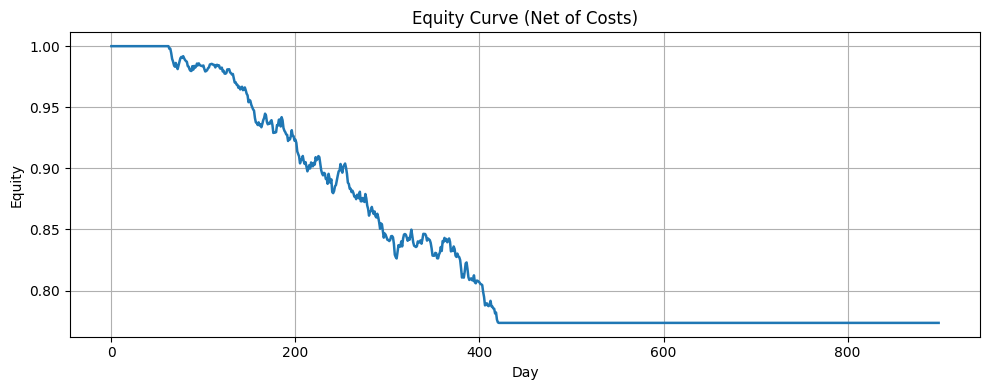

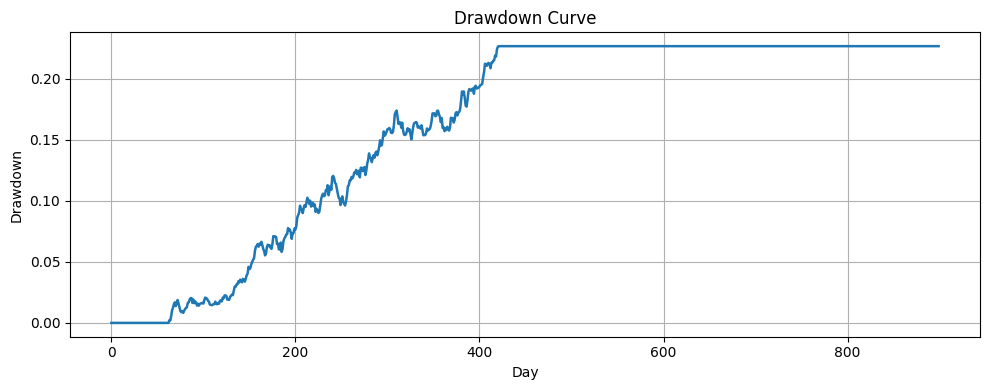

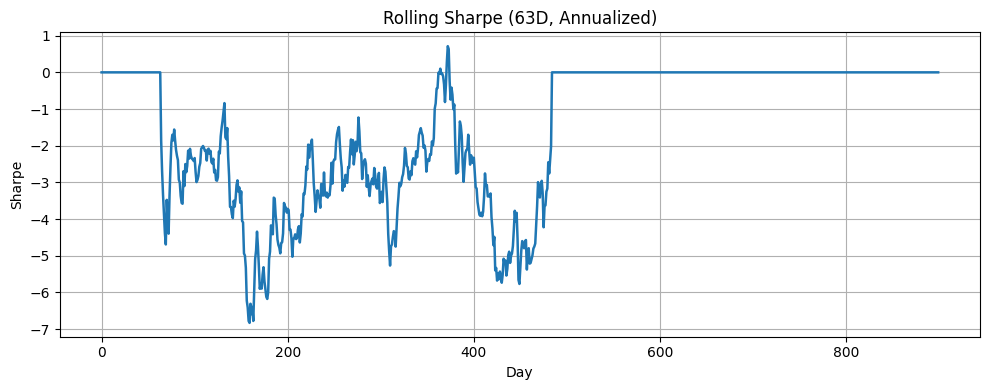

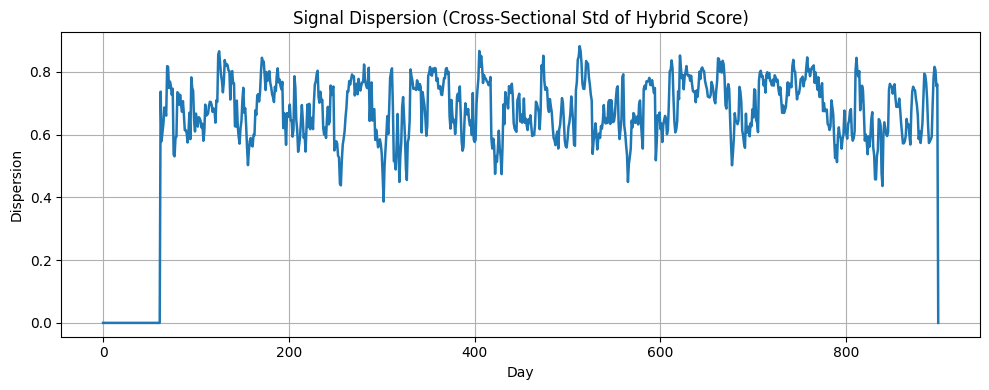

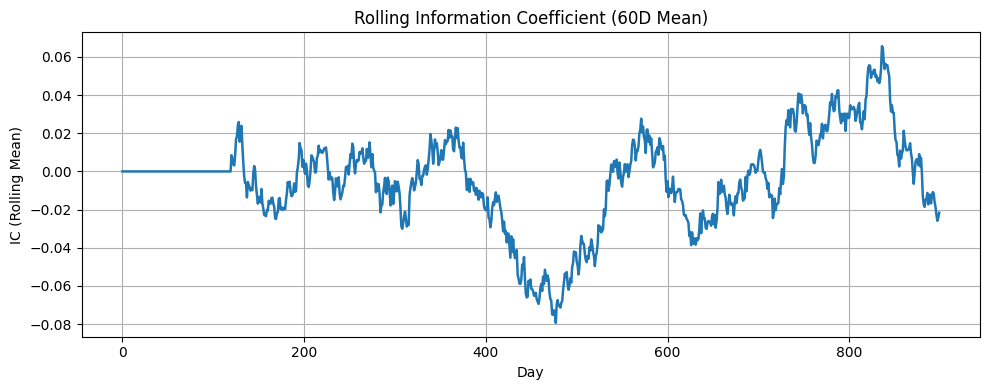

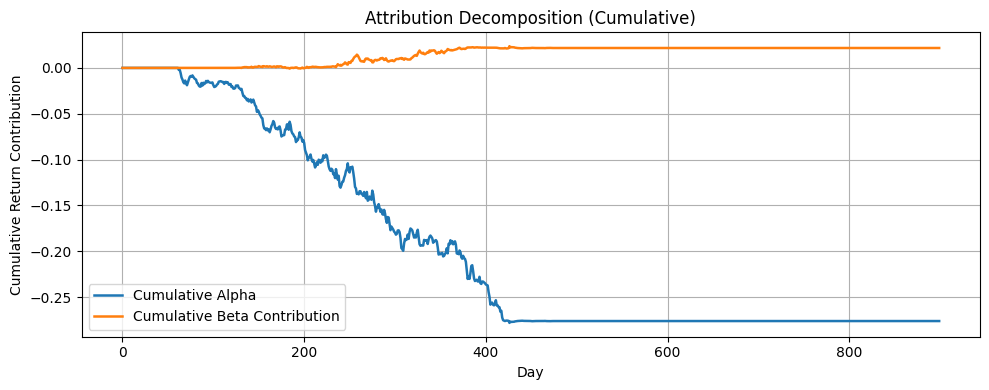

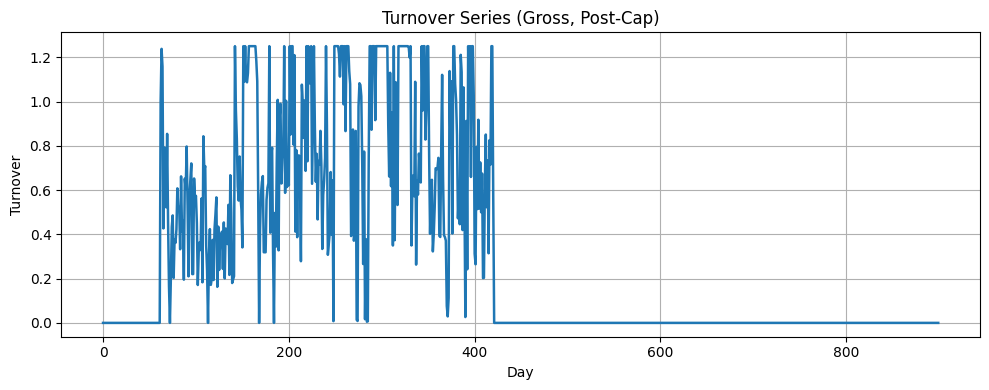

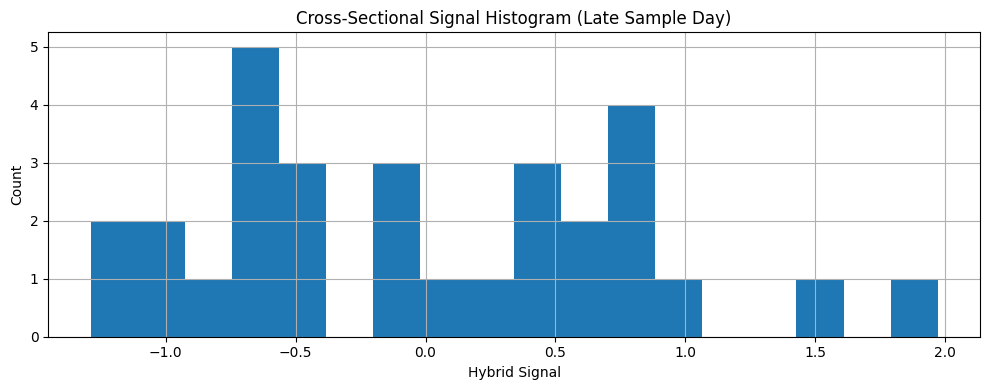

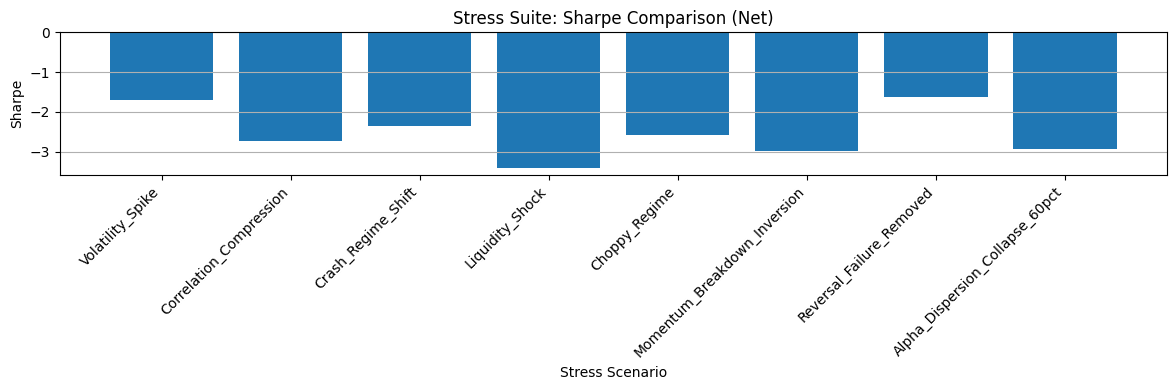

In [26]:

# (No narrative text in this cell.)

t = list(range(T))

# Compute drawdown again for plotting alignment
_, dd_series_plot = max_drawdown(equity)

# Rolling Sharpe already aligned to T: roll_sh_T
# Rolling IC: ic_roll
# Stress Sharpe comparison
stress_names = [r["name"] for r in stress_results]
stress_sharpes = [r["sharpe"] for r in stress_results]

# Cross-sectional signal histogram at a representative late date
t_hist = max(burn + 10, T - 5)
sig_hist = signal[t_hist][:]

plt.figure(figsize=(10, 4))
plt.plot(t, equity, linewidth=1.8)
plt.title("Equity Curve (Net of Costs)")
plt.xlabel("Day")
plt.ylabel("Equity")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, dd_series_plot, linewidth=1.8)
plt.title("Drawdown Curve")
plt.xlabel("Day")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, roll_sh_T, linewidth=1.8)
plt.title("Rolling Sharpe (63D, Annualized)")
plt.xlabel("Day")
plt.ylabel("Sharpe")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, sig_disp, linewidth=1.8)
plt.title("Signal Dispersion (Cross-Sectional Std of Hybrid Score)")
plt.xlabel("Day")
plt.ylabel("Dispersion")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, ic_roll, linewidth=1.8)
plt.title("Rolling Information Coefficient (60D Mean)")
plt.xlabel("Day")
plt.ylabel("IC (Rolling Mean)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, cum_alpha, linewidth=1.8, label="Cumulative Alpha")
plt.plot(t, cum_beta, linewidth=1.8, label="Cumulative Beta Contribution")
plt.title("Attribution Decomposition (Cumulative)")
plt.xlabel("Day")
plt.ylabel("Cumulative Return Contribution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, turnover_ts, linewidth=1.8)
plt.title("Turnover Series (Gross, Post-Cap)")
plt.xlabel("Day")
plt.ylabel("Turnover")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(sig_hist, bins=18)
plt.title("Cross-Sectional Signal Histogram (Late Sample Day)")
plt.xlabel("Hybrid Signal")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(list(range(len(stress_sharpes))), stress_sharpes)
plt.xticks(list(range(len(stress_names))), stress_names, rotation=45, ha="right")
plt.title("Stress Suite: Sharpe Comparison (Net)")
plt.xlabel("Stress Scenario")
plt.ylabel("Sharpe")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW

Cell 10

This cell constructs the maximum audit bundle and completes the institutional research lifecycle. Its purpose is to ensure that the notebook produces a reproducible deliverable package every run: sensitivity surfaces, Monte Carlo robustness envelopes, fragility artifacts, governance classifications, hash registries, and a final zipped bundle suitable for archival and review. In a regulated or litigation-prone environment, the ability to reproduce exactly what was run and what was produced is not optional. It is the core of defensibility.

The parameter sensitivity grid is especially important for Strategy 7 because exhaustion filters introduce multiple degrees of freedom. Momentum lookback length changes the nature of the signal: shorter horizons can increase noise; longer horizons can lag regime shifts. Exhaustion lookbacks and z-thresholds control how frequently names are excluded. The OR/AND logic defines conservatism: OR triggers more exclusions; AND triggers fewer, potentially missing true blow-off episodes. The grid records Sharpe, drawdown, and terminal equity across combinations, revealing whether the policy is stable across a reasonable parameter neighborhood or whether it is knife-edge. Sensitivity is not a moral failing; it is a model risk attribute that must be documented.

The Monte Carlo robustness envelope adds a second layer of skepticism. Rather than relying on a single realized path, the notebook perturbs returns via residual resampling with controlled noise, generating a distribution of terminal outcomes and tail quantiles. This is not a structural simulation of the full market generator, but it provides a practical robustness diagnostic that is computationally feasible and deterministic. For Strategy 7, the tail behavior is particularly relevant: exhaustion filters are designed to mitigate tail drawdowns associated with blow-off reversals, so the distributional perspective matters.

The audit layer then hashes every artifact, builds an artifact hash registry, computes a master bundle hash, and writes an audit index. This creates tamper-evident integrity: if an artifact is modified after the fact, the hash registry will not match. The cell also writes a review checklist that enumerates the professional sign-offs expected: quant research validation of signal logic, model risk validation of fragility and tiering, execution review of cost assumptions, and compliance review of synthetic-only labeling.

The learning objective is to demonstrate what “production-grade” means in research: not that a strategy is ready to deploy, but that the research process is governed, reproducible, transparent, and auditable. Strategy 7 becomes a case study in how a seemingly small design change—an exhaustion filter—propagates through selection, concentration, turnover, costs, stresses, and governance classification, and how a professional laboratory must document that propagation end-to-end.


###10.2.CODE AND IMPLEMENTATION

In [30]:

# -----------------------------
# Parameter Sensitivity Grid
# -----------------------------
grid_mom = [40, 60, 90]
grid_rev = [3, 5, 8]
grid_k = [4, 6, 8]
grid_wm = [0.50, 0.65, 0.80]  # w_rev = 1 - w_mom

def run_quick_grid(Lm_g, Lr_g, k_g, wm_g):
    # Deterministic seed per grid point
    name = f"grid_Lm{Lm_g}_Lr{Lr_g}_K{k_g}_wm{wm_g}"
    seed = int(hashlib.sha256((str(CONFIG["seed"]) + name).encode("utf-8")).hexdigest()[:8], 16)
    rnd = random.Random(seed)

    # Prices from base returns (reuse base returns for speed)
    prices_g = [[100.0]*T for _ in range(N)]
    for i in range(N):
        p = 100.0
        for t in range(T):
            p *= (1.0 + rets[i][t])
            p = max(0.5, p)
            prices_g[i][t] = p

    sig_g = [[0.0]*N for _ in range(T)]
    for t in range(T):
        if t < max(burn, Lm_g + 2, Lr_g + 2) or t >= T-1:
            continue
        mom_vec = [cum_return(prices_g[i], t-Lm_g, t) for i in range(N)]
        rev_vec = [-cum_return(prices_g[i], t-Lr_g, t) for i in range(N)]
        zm, _, _ = zscore(mom_vec)
        zr, _, _ = zscore(rev_vec)

        reg = regimes[t]
        if reg == 1:
            w_m = clamp(wm_g + 0.15, 0.0, 1.0); w_r = 1.0 - w_m
        elif reg == 2:
            w_r = clamp((1.0-wm_g) + 0.20, 0.0, 1.0); w_m = 1.0 - w_r
        elif reg == 3:
            w_m = clamp(wm_g - 0.20, 0.0, 1.0); w_r = 1.0 - w_m
        else:
            w_m = wm_g; w_r = 1.0 - wm_g

        for i in range(N):
            sig_g[t][i] = w_m*zm[i] + w_r*zr[i]

    # Trade quickly (same cost model)
    wloc = [0.0]*N
    pret = [0.0]*T
    eq = 1.0
    peak = 1.0
    cash = False

    for t in range(T-1):
        if t < max(burn, Lm_g + 2, Lr_g + 2):
            continue
        if eq > peak:
            peak = eq
        dd = 0.0 if peak <= 0 else (peak - eq)/peak
        if dd >= CONFIG["dd_stop"]:
            cash = True
        if cash and dd <= (CONFIG["dd_stop"]*0.50):
            cash = False

        desired = [0.0]*N
        if (not cash) and (t % CONFIG["rebal_freq"] == 0):
            order = rank_indices(sig_g[t])
            longs = order[:k_g]
            shorts = order[-k_g:]
            for i in longs:
                desired[i] = +1.0/k_g
            for i in shorts:
                desired[i] = -1.0/k_g
            g = sum(abs(x) for x in desired)
            if g > 1e-12:
                desired = [x/g for x in desired]
            gross = sum(abs(x) for x in desired)
            if gross > CONFIG["max_gross_leverage"]:
                desired = [x*(CONFIG["max_gross_leverage"]/gross) for x in desired]

        turnover = sum(abs(desired[i]-wloc[i]) for i in range(N))
        if turnover > CONFIG["turnover_cap_daily"] and turnover > 1e-12:
            frac = CONFIG["turnover_cap_daily"]/turnover
            desired = [wloc[i] + frac*(desired[i]-wloc[i]) for i in range(N)]
            turnover = sum(abs(desired[i]-wloc[i]) for i in range(N))

        cost = apply_costs(turnover, liq_mult[t])
        wloc = desired[:]
        net_ret = sum(wloc[i]*rets[i][t+1] for i in range(N)) - cost
        pret[t+1] = net_ret
        eq *= (1.0 + net_ret)

    # Compute MDD from reconstructed equity curve (lightweight)
    eq_series = [1.0]*T
    e = 1.0
    for t in range(1, T):
        e *= (1.0 + pret[t])
        eq_series[t] = e
    mdd_g, _ = max_drawdown(eq_series)
    sh_g = annualize_sharpe(pret[1:])
    return float(sh_g), float(mdd_g), float(eq)

grid_results = []
for Lm_g in grid_mom:
    for Lr_g in grid_rev:
        for k_g in grid_k:
            for wm_g in grid_wm:
                sh_g, mdd_g, teq = run_quick_grid(Lm_g, Lr_g, k_g, wm_g)
                grid_results.append({
                    "mom_lookback": Lm_g,
                    "rev_lookback": Lr_g,
                    "top_k": k_g,
                    "w_mom": wm_g,
                    "w_rev": 1.0 - wm_g,
                    "sharpe": sh_g,
                    "max_drawdown": mdd_g,
                    "terminal_equity": teq
                })

write_json(os.path.join(DELIV_DIR, "parameter_sensitivity.json"),
          facts={"run_id": RUN_ID},
          assumptions={"grid_reuses_base_market": True},
          open_items=["Extend grid to include cost parameters and turnover cap for full policy surface mapping."],
          analysis={"grid_points": len(grid_results)},
          outputs={"grid": grid_results})

# -----------------------------
# Monte Carlo Robustness Envelope (>=200)
# -----------------------------
MC = 10

def monte_carlo_envelope():
    # Perturb realized daily strategy returns via deterministic residual resampling + mild noise
    base = port_ret_ts[1:]
    mu = safe_mean(base)
    centered = [x - mu for x in base]
    out = []
    for k in range(MC):
        seed = int(hashlib.sha256((RUN_ID + f"_mc_{k}").encode("utf-8")).hexdigest()[:8], 16)
        rnd = random.Random(seed)
        eq = 1.0
        path = [1.0]
        for _ in range(len(centered)):
            e = centered[rnd.randrange(0, len(centered))]
            noise = rnd.gauss(0.0, 0.15 * safe_std(centered)) if len(centered) > 2 else 0.0
            r = mu + e + noise
            eq *= (1.0 + r)
            path.append(eq)
        out.append({"terminal_equity": float(eq), "path_tail": [float(x) for x in path[-60:]]})
    terminals = sorted([x["terminal_equity"] for x in out])
    p5 = terminals[int(0.05*(len(terminals)-1))]
    p50 = terminals[int(0.50*(len(terminals)-1))]
    p95 = terminals[int(0.95*(len(terminals)-1))]
    return out, {"p5": float(p5), "p50": float(p50), "p95": float(p95)}

mc_paths, mc_stats = monte_carlo_envelope()

write_json(os.path.join(DELIV_DIR, "monte_carlo_envelope.json"),
          facts={"run_id": RUN_ID},
          assumptions={"mc_resamples_strategy_residuals": True, "deterministic_seeds_per_sim": True},
          open_items=["Consider joint resimulation of market and execution for full structural MC."],
          analysis={"mc_runs": MC, "terminal_quantiles": mc_stats},
          outputs={"summary": mc_stats, "samples": mc_paths})

# -----------------------------
# Review Checklist (committee-ready scaffold)
# -----------------------------
review = {
    "run_id": RUN_ID,
    "required_reviews": [
        "Quant Research Lead: signal validity & leakage review",
        "Model Risk: fragility, stress battery, tiering thresholds",
        "Execution/Trading: cost model plausibility and capacity constraints",
        "Risk: drawdown controls and leverage limits",
        "Compliance: synthetic-only labeling and non-deployment disclaimers"
    ],
    "evidence_expected": [
        "Artifact hash registry",
        "Reproducibility checksums",
        "Stress suite deltas vs base",
        "Sensitivity surface summary",
        "Monte Carlo tail envelope"
    ]
}
write_json(os.path.join(DELIV_DIR, "review_checklist.json"),
          facts={"run_id": RUN_ID},
          assumptions={},
          open_items=["Attach sign-off records in enterprise workflow."],
          analysis={},
          outputs=review)

# -----------------------------
# Tamper-evident artifact hashing + audit index + lab bundle
# -----------------------------
artifact_paths = []
for fn in ["run_manifest.json", "prompts_log.jsonl", "risk_log.json"]:
    artifact_paths.append(os.path.join(ROOT, fn))

for fn in os.listdir(DELIV_DIR):
    artifact_paths.append(os.path.join(DELIV_DIR, fn))

hash_registry = {}
for p in sorted(artifact_paths):
    if os.path.isfile(p):
        hash_registry[os.path.relpath(p, ROOT)] = _sha256_file(p)

master_blob = json.dumps(hash_registry, sort_keys=True).encode("utf-8")
master_bundle_hash = _sha256_bytes(master_blob)

write_json(os.path.join(DELIV_DIR, "artifact_hash_registry.json"),
          facts={"run_id": RUN_ID},
          assumptions={"sha256_used": True},
          open_items=[],
          analysis={"master_bundle_hash": master_bundle_hash},
          outputs={"hashes": hash_registry, "master_bundle_hash": master_bundle_hash})

audit_index = {
    "run_id": RUN_ID,
    "timestamp_utc": RUN_TS,
    "strategy": {"id": CONFIG["strategy_id"], "name": CONFIG["strategy_name"]},
    "integrity": {"master_bundle_hash_sha256": master_bundle_hash},
    "artifacts": sorted(list(hash_registry.keys()))
}
write_json(os.path.join(DELIV_DIR, "audit_index.json"),
          facts={"run_id": RUN_ID, "timestamp_utc": RUN_TS},
          assumptions={"audit_index_is_manifest_of_artifacts": True},
          open_items=[],
          analysis={},
          outputs=audit_index)

# Final bundle zip
bundle_path = os.path.join(ROOT, "lab_bundle.zip")
with zipfile.ZipFile(bundle_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    # Root files
    z.write(RUN_MANIFEST_PATH, arcname="run_manifest.json")
    z.write(PROMPTS_LOG_PATH, arcname="prompts_log.jsonl")
    z.write(RISK_LOG_PATH, arcname="risk_log.json")
    # Deliverables
    for fn in os.listdir(DELIV_DIR):
        z.write(os.path.join(DELIV_DIR, fn), arcname=os.path.join("deliverables", fn))

# Final note in manifest outputs (overwrite with final outputs pointer)
write_json(RUN_MANIFEST_PATH,
          facts=manifest["facts_provided"],
          assumptions=manifest["assumptions"],
          open_items=manifest["open_items"],
          analysis=manifest["analysis"],
          outputs={
              "synthetic_market_summary": mkt_summary,
              "final_bundle": {"path": "lab_bundle.zip", "master_bundle_hash_sha256": master_bundle_hash}
          })


##11.CONCLUSION

**Conclusion**

This laboratory was built to cultivate a specific kind of professional intuition: the ability to read a strategy as an interaction between **mechanism**, **constraints**, and **execution**, rather than as a single time series of returns. Strategy 7, **Momentum with Exhaustion Filter**, is particularly well suited to that lesson because it sits exactly on the boundary between an appealing theoretical narrative and a fragile real-world implementation. Momentum is easy to describe and difficult to govern. Exhaustion filters are easy to justify and easy to misuse. The notebook’s contribution is to make those tensions explicit and testable in a controlled, auditable setting.

The central structural insight is that momentum is not “one thing.” It is a family of behaviors that depends on regime geometry. In trend regimes, continuation can be sustained because the market’s risk geometry is permissive: volatility is moderate, correlation is not fully compressed, liquidity is adequate, and constraints bind slowly. In crash regimes or stress transitions, the geometry flips: correlations compress, volatility rises, liquidity deteriorates, and forced de-risking can synchronize exits. The same momentum exposure that benefited from continuation becomes a concentrated bet on crowded winners that must be unwound in an unfavorable execution surface. This is not a moral critique of momentum; it is the mechanism of constraint bindingness.

The exhaustion filter changes the strategy not by forecasting reversals, but by changing the feasible set of exposures. It expresses a risk hypothesis: when a name has experienced an extreme recent move or a volatility spike relative to the cross-section, the continuation mechanism may have entered a late-stage, crowded state. Excluding those names is a form of endogenous risk control: it is a constraint-aware rule that prevents the policy from climbing the steepest part of the momentum surface when that steepness is likely to be associated with instability. In the laboratory, this is operationalized through z-score thresholds on recent returns and realized volatility, combined via a chosen logic (OR or AND). The point is not that one threshold is “correct.” The point is that each choice implies a different trade-off between participation and risk.

That trade-off is visible in the diagnostics. A well-behaved exhaustion filter can reduce drawdown in regimes where blow-off dynamics are present, but it can also create new fragility modes. One fragility mode is **false exhaustion**: the filter fires frequently in a genuinely trending environment because volatility rises as trends mature, leading the strategy to step aside too early and convert momentum into under-exposure. Another fragility mode is **filter whipsaw**: in choppy regimes with repeated volatility bursts, the filter can repeatedly exclude and re-include names, increasing turnover and pushing the strategy into the steep part of the execution surface. A third fragility mode is **cross-sectional concentration**: if the filter excludes many candidates at once, the top-K portfolio can become narrower, increasing HHI and amplifying idiosyncratic risk even in a long-only sleeve.

The stress suite reinforces the mechanism-first framing. Generic stresses (volatility spikes, correlation compression, liquidity shocks, crash regime shifts) show how the same policy behaves under different market geometries. Strategy-specific stresses are more revealing because they attack the hypothesis directly. If momentum is inverted or if a momentum crash is embedded, an exhaustion filter may not help; the strategy can still fail because the primary mechanism is broken. If the exhaustion detection is degraded—by raising thresholds, by changing OR to AND logic, or by injecting noise—risk control benefits can disappear while turnover remains. These outcomes are not failures of the notebook; they are the point. They demonstrate that “risk filters” are not universally protective. They are mechanisms with their own regimes of validity.

Execution realism dominates theory throughout. The laboratory explicitly prices the act of changing exposure through spread, slippage, and turnover-dependent impact scaled by liquidity stress. This is essential because exhaustion is most likely to fire when volatility rises, and volatility rises precisely when execution deteriorates. A naive evaluation that ignores costs may conclude that the filter improves outcomes simply by avoiding reversals. A realistic evaluation shows a deeper story: filters can reduce exposure to unstable names but increase the frequency of portfolio reshaping, which can create an execution tax that accumulates silently. This is why professional research cannot stop at signal construction. The policy must be evaluated on the full path: signal → portfolio → trades → costs → realized exposure.

From a governance perspective, the notebook demonstrates how to treat a strategy as a model subject to audit. The artifact set is not administrative overhead; it is how the research becomes defensible. Strategy 7 is parameter-sensitive by nature: lookback windows, threshold levels, and filter logic can materially alter turnover, concentration, and regime exposure. In institutional contexts, that sensitivity is a model risk input. The notebook therefore includes parameter sensitivity grids, a Monte Carlo robustness envelope, and fragility scoring that converts stress outcomes into governance tiering and deployment classification. The result is not a binary “works/doesn’t work” judgment. The result is an evidence package that supports disciplined decision-making and highlights open items that require independent review.

The most productive way to iterate is experimental, not promotional. The notebook invites controlled perturbations that isolate causal channels. One class of experiments targets the exhaustion mechanism itself: vary the z-score thresholds, change OR to AND logic, alter the recent-return window, and measure how dispersion, turnover, and drawdown respond. Another class targets market structure: increase correlation compression in stress regimes, intensify liquidity multipliers, or alter the frequency and severity of blow-off episodes to study where the filter becomes essential or where it becomes too conservative. A third class targets execution: adjust impact convexity to study capacity cliffs, tighten turnover caps to model operational constraints, and observe when the strategy becomes “signal-rich but execution-poor.”

The notebook should be read as a laboratory, not a trading system. Its purpose is to teach how a strategy’s apparent logic can dissolve under regime shifts and execution constraints, and how a well-motivated filter can both improve and endanger the policy depending on the surface geometry. The durable lesson is that professional strategy design is not about finding a clever statistic. It is about understanding the mapping from market structure to feasible action, and about governing that mapping with auditable controls. Strategy 7 is a particularly clear example: momentum provides a strong behavioral narrative, exhaustion provides a sensible risk narrative, and execution provides the reality constraint that determines whether either narrative survives in practice.
